In [1]:
from lightgbm.sklearn import LGBMRegressor
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import KFold
from functools import partial
import hyperopt,matplotlib
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import itertools
import joblib
import warnings
import os

warnings.filterwarnings('ignore')

train = pd.read_csv('temperature_dataset/train.csv', index_col=0)
test = pd.read_csv('temperature_dataset/test.csv', index_col=0)
sample_submission = pd.read_csv('temperature_dataset/sample_submission.csv', index_col=0)

In [2]:
##파생변수 누적측정치를 10분단위 측정치로 변환
def non_cumulative(df,str):
    Non_Comulative=[]
    Non_Comulative.append(0.0)
    for i in range(len(df)):
        if i<len(df)-1:
            temp=df[str].iloc[i+1]-df[str].iloc[i]
            if temp<0:
                temp=0.0
            Non_Comulative.append(temp)
        else:
            break
    return  Non_Comulative

##파생변수 누적측정치를 10분 단위 측청치로 변환된것을 합치는 함수
def non_cumulative_concat(df,df_columns):
    non_cumulative_feature=pd.DataFrame()
    for columns in df_columns:
        temp=non_cumulative(df,columns)
        temp=pd.DataFrame(temp)
        non_cumulative_feature=pd.concat([non_cumulative_feature,temp],axis=1)
    
    return non_cumulative_feature

##5개의 관측소에서 측청된 가상자료를 평균을 구하여 차원을 축소한다.
def mean_feature(df):
    df['Mean_Temperature']=(df['X00']+df['X07']+df['X28']+df['X31']+df['X32'])/5.0 ##Mean_Temperature
    df['Mean_Atmospheric_Pressure']=(df['X01']+df['X06']+df['X22']+df['X27']+df['X29'])/5.0 #Mean_Atmospheric pressure
    df['Mean_Wind_Speed']=(df['X02']+df['X03']+df['X18']+df['X24']+df['X26'])/5.0 #Mean_Wind speed
    df['Mean_Cumulative_Precipitation']=(df['X04']+df['X10']+df['X21']+df['X36']+df['X39'])/5.0 #Mean_Cumulative Precipitation
    df['Mean_Barometric_pressure']=(df['X05']+df['X08']+df['X09']+df['X23']+df['X33'])/5.0 #Mean_Barometric pressure
    df['Mean_Cumulative Insolation']=(df['X11']+df['X34'])/2.0  #Mean_Cumulative Insolation
    df['Mean_Humidity']=(df['X12']+df['X20']+df['X30']+df['X37']+df['X38'])/5.0 #Mean_Humidity
    df['Mean_Wind direction']=(df['X13']+df['X15']+df['X17']+df['X25']+df['X35'])/5.0 #Mean_Wind direction
    df['Mean_insolation']=(df['X40']+df['X44'])/2.0  #mean insolation
    df['Mean_Precipitation']=(df['X45']+df['X46']+df['X47']+df['X48']+df['X49'])/5.0 #Mean Precipitation
    return df

##파생변수 체감온도 
def Bodily_temperature(df):
    df['Bodily_temperature']=13.12+0.6215*df['Mean_Temperature']-11.37*df['Mean_Wind_Speed']**0.16+0.3965*df['Mean_Wind_Speed']**0.16*df['Mean_Temperature']
    return df

##파생변수 시간 변수
def time_encoder(df,time):
    df['time']=0
    for i in range(144*time):
        df['time'].iloc[i]=i%144 #minute
    df['time']=np.cos((np.pi/2)*df['time']/144)
    return df

In [13]:
##train dataset feauter 생성
Isolation_columns=['X11','X14','X16','X19','X34']
Precipitation_columns=['X04','X10','X21','X36','X39']
##누적 측정치를 10분단위 측정치로 변환
non_cumulative_isolation=non_cumulative_concat(train,Isolation_columns)
non_cumulative_precipitation=non_cumulative_concat(train,Precipitation_columns)

non_cumulative_isolation.columns=['X40','X41','X42','X43','X44']
non_cumulative_precipitation.columns=['X45','X46','X47','X48','X49']

train=pd.concat([train,non_cumulative_isolation],axis=1)
train=pd.concat([train,non_cumulative_precipitation],axis=1)
#차원 축소
train=mean_feature(train)
#체감온도
train=Bodily_temperature(train)
#시간변수
train=time_encoder(train,33)

In [15]:
##30일(Y00~Y17존재) 3일(Y18존재) 데이터로 나눔
X_train=train.iloc[:4320]
X_train=X_train.loc[:,'Mean_Temperature':'time']

X_test=train.iloc[4321:]
X_test=X_test.loc[:,'Mean_Temperature':'time']

y_test=train.iloc[4321:]
y_test=y_test['Y18']
test=test.loc[:,'Mean_Temperature':'time']

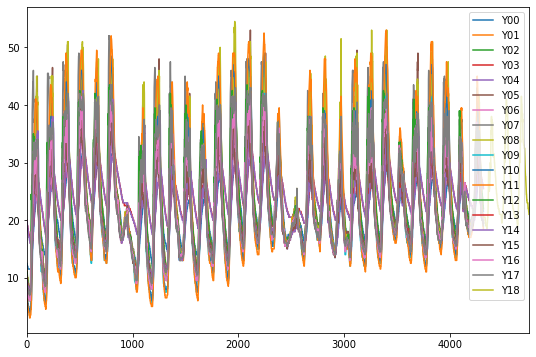

In [5]:
train.loc[:,'Y00':'Y18'].plot(figsize=(9,6))

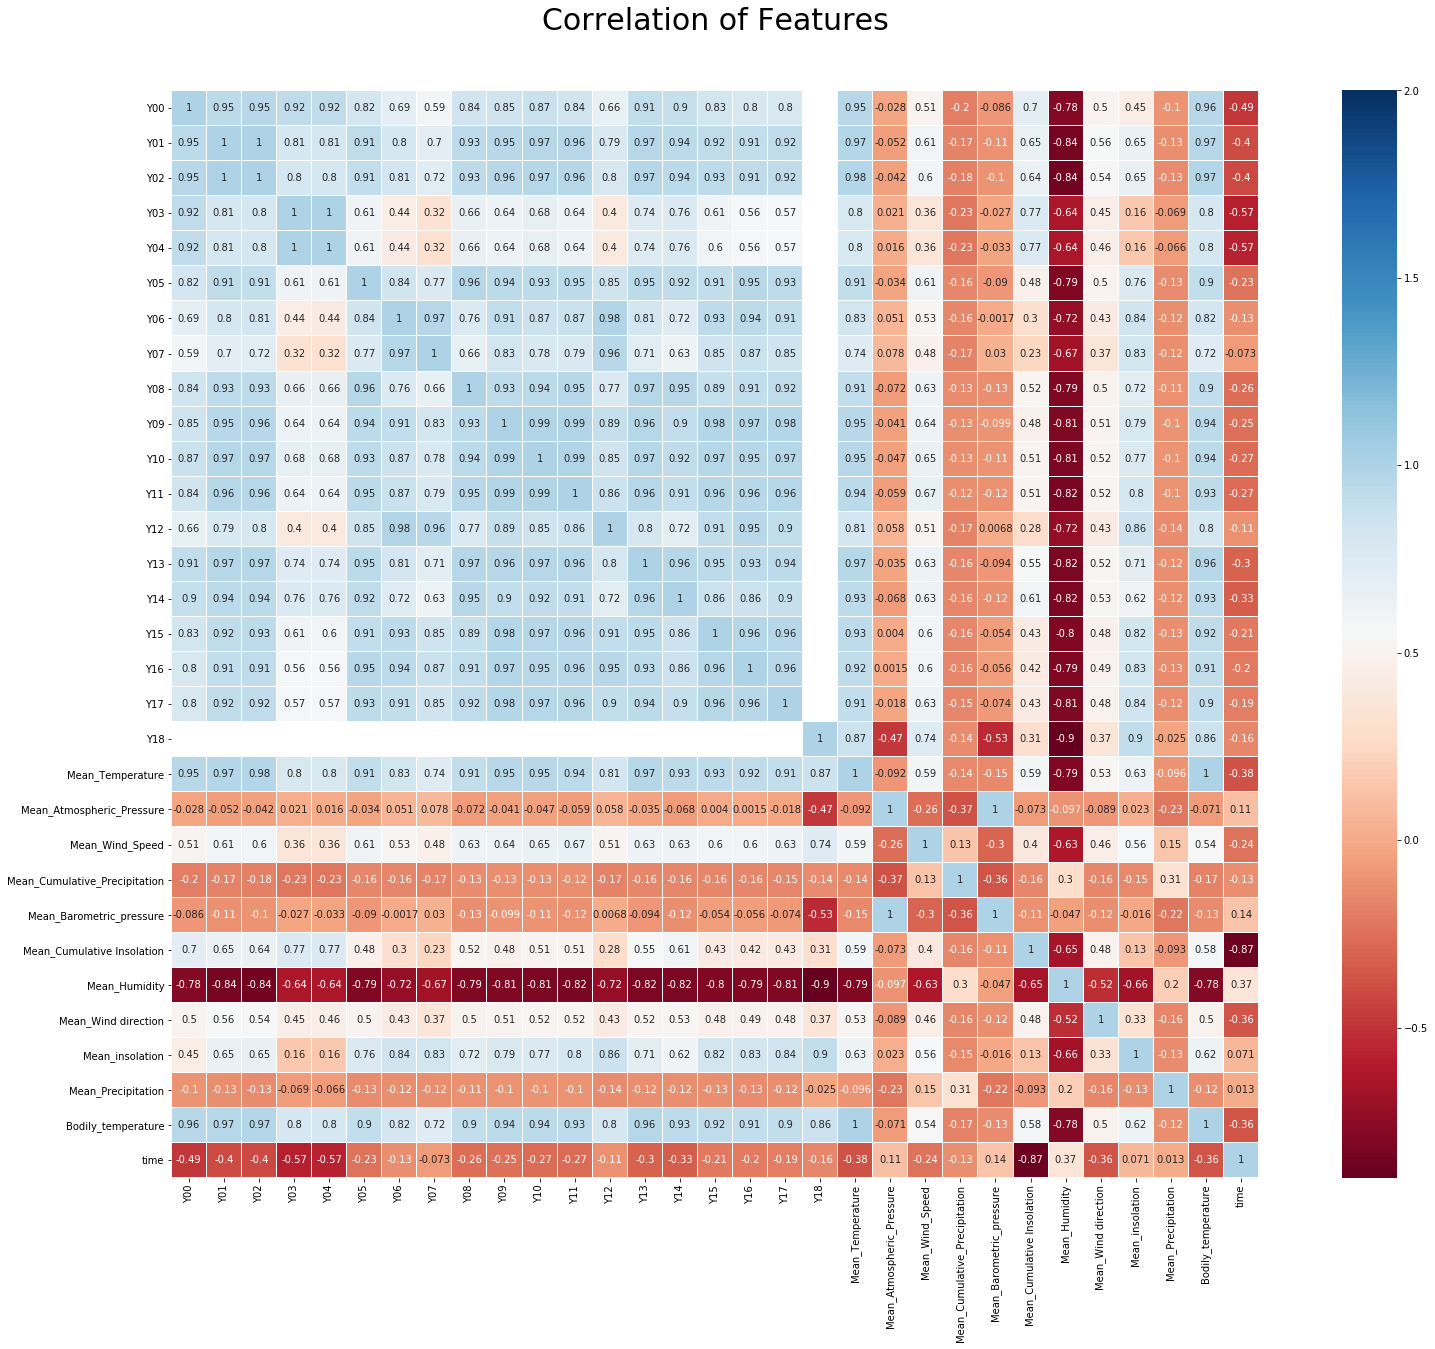

In [6]:
colormap = plt.cm.RdBu
drop_columns=['X40','X41','X42','X43','X44','X45','X46','X47','X48','X49']

temp=train.loc[:,'Y00':'time']
corr=temp.drop(columns=drop_columns).corr()

plt.figure(figsize=(30, 20))
plt.title('Correlation of Features', y=1.05, size=30)
sns.heatmap(corr, linewidths=0.01,vmax=2.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

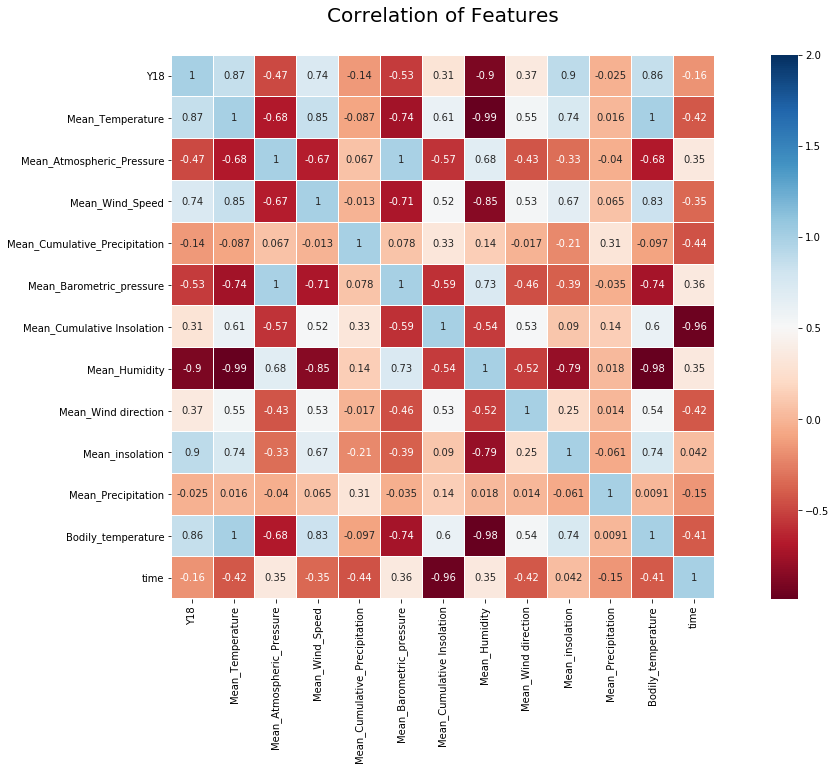

In [7]:
drop_columns=['X40','X41','X42','X43','X44','X45','X46','X47','X48',
              'X49','Y00','Y01','Y02','Y03','Y04','Y05','Y06','Y07',
              'Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17']

temp=train.iloc[4321:]
temp=temp.loc[:,'Y00':'time']

corr=temp.drop(columns=drop_columns,axis=1).corr()
plt.figure(figsize=(20, 10))
plt.title('Correlation of Features', y=1.05, size=20)
sns.heatmap(corr, linewidths=0.01,vmax=2.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [8]:
##loss 정의
def mse_AIFrenz(y_true, y_pred, **kwargs):
    '''
    y_true: 실제 값
    y_pred: 예측 값
    '''
    diff = abs(y_true - y_pred)
    
    less_then_one = np.where(diff < 1, 0, diff)
    
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    return score

##lgbm custom loss
def mse1(y_pred, dataset):
    y_true = dataset.get_label()

    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return 'score', score, False

In [12]:
##function lgb_train
drop_feature=['Mean_Cumulative_Precipitation','Mean_Precipitation']
X_train=X_train.drop(columns=drop_feature)
X_test=X_test.drop(columns=drop_feature)
test=test.drop(columns=drop_feature)

def lgb_train(X_train,y_train, params):
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_model = lgb.train(params, 
                       lgb_train,
                       feval=mse1,
                       valid_sets=[lgb_train],
                       verbose_eval=False)
    return lgb_model

# lgb basic pparams
params = {
    'learning_rate' : 0.1,
    'n_estimators' : 100,
    'objective' : 'regression',
    'metric' : 'mse1',
    'boosting_type' : 'gbdt',
    'n_jobs': -1
}

##각 Y값마다 train한후 예측한값을  Y18과 비교
col=['Y00','Y01','Y02','Y03','Y04','Y05','Y06','Y07','Y08',
     'Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17']

y_pred=pd.DataFrame()

##Y05, Y07, Y08,Y13, Y14는 이상치들이 존재 모델링시 log를 씌운다.
temp_y=train.iloc[:4320]
temp_y=temp_y.loc[:,'Y00':'Y18']

for i in col:
    y_train=temp_y[i]
    ##Y05, Y07, Y08, Y13, Y14는 이상치들이 존재 모델링시 log를 씌운다.
    if i=='Y05'or i=='Y07' or i=='Y08' or i=='Y13' or i=='Y14':
        lgb_model = lgb_train(X_train,np.log(y_train),params)
        pred=np.exp(lgb_model.predict(X_test))
    else:
        lgb_model = lgb_train(X_train,y_train,params)
        pred=lgb_model.predict(X_test)
    y_pred[i]=pred
    print('%s_mse : %f' %(i,mse_AIFrenz(y_test,pred)))

KeyError: "['Mean_Cumulative_Precipitation' 'Mean_Precipitation'] not found in axis"

In [ ]:
#예측한 값과 Y18과의 상관관계 비교
Y18=y_test.reset_index(drop= True)
y_pred=pd.concat([y_pred,Y18],axis=1)

corr=y_pred.corr()
plt.figure(figsize=(20, 10))
plt.title('Y00-Y18 Correlation', y=1.05, size=20)
sns.heatmap(corr, linewidths=0.01,vmax=2.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
##예측한 Y값과 Y18값의 boxplot
y_pred.boxplot(figsize=(9,6))

4. 변수 선택 및 모델 구축
Feature Engineering & Initial Modeling
Y18을 잘 예측할수있는 Y00~Y17의 ensemble 조합을 찾는게 목표
Y00~Y17을 combination 조합으로 실험하여 ensemble을 진행
Y02, Y06, Y07, Y10, Y12을 target값으로 훈련하여 ensemble을 했을 때 Y18을 잘 예측함
최종적으로 Y02, Y06, Y07, Y10, Y12, Y18을 target값으로 훈련하여 최종 submission 파일을 생성함

In [ ]:
def best_Y_ensemble_search(X_train, temp_y, X_test, y_test, col, counts, params):
    #col에 있는 Y값중 counts개를 중복없이 뽑는다.
    total = list(itertools.combinations(col,counts))
    mse=4
    for col in total:
        pred=np.zeros((len(X_test)))
        col=list(col)
        #train의 마지막 3일치인 Y18값을 추가해서 ensemble진행
        col.append('Y18')
        
        for i in col:
            y_train=temp_y[i]
            ##Y05, Y07, Y08, Y13, Y14는 이상치들이 존재 모델링시 log를 씌운다.
            if i=='Y05'or i=='Y07' or i=='Y08' or i=='Y13' or i=='Y14':
                lgb_model = lgb_train(X_train,np.log(y_train),params)
                #모델링시 log를 씌운것을 역변환
                pred+=np.exp(lgb_model.predict(X_test))
            
            elif i=='Y18':
                lgb_model = lgb_train(X_test,y_test,params)
                pred+=lgb_model.predict(X_test)
            
            else:
                lgb_model = lgb_train(X_train,y_train,params)
                pred+=lgb_model.predict(X_test)
        
        pred=pred/len(col)
        ##최소 mse를 계속 갱신
        if mse>mse_AIFrenz(y_test,pred):
            mse=mse_AIFrenz(y_test,pred)
            print('select_y: %s, mse : %f' %(col, mse))
            best_mse_y=col
            
    return best_mse_y

In [ ]:
#lgb basic params
params = {
    'learning_rate' : 0.1,
    'n_estimators' : 100,
    'objective' : 'regression',
    'metric': 'mse1',
    'boosting_type' : 'gbdt',
    'n_jobs': -1
}

best_y=[]

##상관계수가 낮은 Y00,Y03,Y04 값은 제거(0.7이하)
col=['Y01','Y02','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y15','Y16','Y17']

#Y컬럼중 5개를 중복없이 뽑는다는 조합의 개념
counts=5
best_y=best_Y_ensemble_search(X_train, temp_y, X_test, y_test, col, counts, params)

In [ ]:
##튜닝할 파리미터와 범위 지정
hyper_space = {'n_estimators': hp.choice('n_estimators',np.arange(50, 150, 10, dtype=int)),
               'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
               'colsample_bytree': hp.uniform('colsample_bytree', 0, 1.0),
               'feature_fraction': hp.uniform('feature_fraction',0, 1.0),
               "bagging_fraction": hp.uniform("bagging_fraction", 0, 1.0),
               'max_depth':  hp.choice('max_depth',np.arange(-1, 16, 1, dtype=int)),
               'num_leaves': hp.choice('num_leaves',np.arange(16, 1024, 16, dtype=int)),
               'subsample': hp.uniform('subsample', 0, 1.0),
               'min_child_weight': hp.choice('min_child_weight',np.arange(1, 8, 1, dtype=int))
              }

##ensemble score을 산출하기 위한 함수
def ensemble_train_score(model,X_train ,temp_y, X_test, y_test ,col):
    pred=[]
    col=list(col)
    for i in col:
        y_train=temp_y[i]
        ##Y05, Y07, Y08, Y13, Y14는 이상치들이 존재 모델링시 log를 씌운다.
        if i=='Y05'or i=='Y07' or i=='Y08' or i=='Y13' or i=='Y14':
            lgb_model=model.fit(X_train,np.log(y_train))
            #모델링시 log를 씌운것을 역변환
            pred.append(np.exp(lgb_model.predict(X_test)))
        
        elif i=='Y18': 
            lgb_model = model.fit(X_test,y_test)
            pred.append(lgb_model.predict(X_test))
        
        else:
            lgb_model=model.fit(X_train,y_train)
            pred.append(lgb_model.predict(X_test))
    
    pred=np.mean(pred,axis=0)
    mse=mse_AIFrenz(y_test,pred)
    
    return mse


def evaluate(params, X_train, temp_y, X_test, y_test, col):
    
    # Initilize instance of estimator
    est = LGBMRegressor(objective='regression', n_jobs=-1, random_state=2018)
    # Set params
    est.set_params(**params)
    #score
    score = ensemble_train_score(est, X_train, temp_y, X_test, y_test, col)
    return score

In [ ]:
##best_y
best_y=['Y02','Y06','Y07','Y10','Y12','Y18']

##hyperopt_objective
hyperopt_objective = lambda params: evaluate(params, X_train, temp_y, X_test, y_test, best_y)
trials = Trials()

# Set algoritm parameters
algo = partial(tpe.suggest, 
            n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)
 
# Fit Tree Parzen Estimator
best_vals = fmin(hyperopt_objective, space=hyper_space,
                 algo=algo, max_evals=5500, trials=trials,
                 rstate=np.random.RandomState(seed=2018))
    
print("ENSEMBLE %d :" %(len(col)))
    # Print best parameter
best_params=space_eval(hyper_space, best_vals)
print("BEST PARAMETERS: " + str(best_params))
    
scores = [trial['result']['loss'] for trial in trials.trials]
print("BEST SCORE: " + str(np.min(scores)))

# Print execution time
tdiff = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
print("ELAPSED TIME: " + str(tdiff.total_seconds() / 60))

In [ ]:
#lgbm best parameter
params=  {'bagging_fraction': 0.8730026007798204,
          'colsample_bytree': 0.23003900797784482,
          'feature_fraction': 0.9623680621083347, 
          'learning_rate': 0.19953498069017073,
          'max_depth': 3, 
          'min_child_weight': 2, 
          'n_estimators': 140, 
          'num_leaves': 496, 
          'subsample': 0.7796739945911554}

##train
kfold = KFold(n_splits=4, random_state = 2018, shuffle = True)

for i in best_y:
    y_train=temp_y[i]
    if i=='Y18': 
        lgb_model = lgb_train(X_test,y_test,params)
        joblib.dump(lgb_model, './model/lgb_%s.pkl'%(i))   
    else:
        for n, (train_idx, validation_idx) in enumerate(kfold.split(X_train,y_train)):
            kf_x_train, x_validation = X_train.iloc[train_idx], X_train.iloc[validation_idx]
            kf_y_rain, y_validation = y_train.iloc[train_idx], y_train.iloc[validation_idx]
            
            if i=='Y05'or i=='Y07' or i=='Y08' or i=='Y13' or i=='Y14':
                lgb_model=lgb_train(kf_x_train,np.log(kf_y_rain),params)
                joblib.dump(lgb_model, './model/lgb_kfold_%s_%d.pkl'%(i,n))
            else:
                lgb_model=lgb_train(kf_x_train,kf_y_rain,params)
                joblib.dump(lgb_model, './model/lgb_kfold_%s_%d.pkl'%(i,n))

In [ ]:
final_pred=[]
kfold_pred=[]

for i in best_y:
    pred=np.zeros(len(test))
    if i=='Y18':
        lgb_model=joblib.load('./model/lgb_%s.pkl'%(i))
        final_pred.append(lgb_model.predict(test))
    else:
        for n in range(4):
            lgb_model=joblib.load('./model/lgb_kfold_%s_%d.pkl'%(i,n))
            ##모델링시 log를 씌운것을 역변환
            if i=='Y05'or i=='Y07' or i=='Y08' or i=='Y13' or i=='Y14':
                pred+=np.exp(lgb_model.predict(test))
            else:
                pred+=lgb_model.predict(test)
        #kfold 평균값 산출
        pred=pred/4.0
        final_pred.append(pred)  

##평균 앙상블 진행       
final_prediction=np.mean(final_pred,axis=0)
submission = pd.DataFrame(data=final_prediction, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission.csv', index=True)
submission